Based on https://github.com/blueprints-for-text-analytics-python/blueprints-text

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/furyhawk/text_summarization/raw/master'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


In [2]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

In [3]:
pd.options.display.max_colwidth = 150 ###
file = "un-general-debates-blueprint.csv"
file = f"{BASE_DIR}/data/un-general-debates/un-general-debates.csv.zip" ### real location
df = pd.read_csv(file)
df.sample(2, random_state=53)

,session,year,country,text
3871,42,1987,HND,"﻿On behalf of the Government of Honduras I extend to you, Sir, sincere congratulations on your election as President of the forty-second session o..."
4697,35,1980,THA,﻿My delegation takes pleasure in extending to Mr. Riidiger von Wechmar its sincere congratulations on his unanimous election to the presidency of ...


## Load BBC News summary dataset

Check if dataset has already been saved, read from cvs if yes.

In [66]:
root_path = f'../data/BBC News Summary'


# root_path = f'/kaggle/input/bbc-news-summary/BBC News Summary'


def loadDataset(root_path):

    types_of_articles = ['business',
                         'entertainment', 'politics', 'sport', 'tech']
    df = pd.DataFrame(columns=['title', 'article', 'summary'])

    for type_of_article in types_of_articles:
        # type_of_article = 'business'  # entertainment, politices, sport, tech
        num_of_article = len(os.listdir(
            f"{root_path}/News Articles/{type_of_article}"))

        print(f'"Reading {type_of_article} articles"')
        dataframe = pd.DataFrame(
            columns=['title', 'article', 'summary', 'category'])

        for i in tqdm(range(num_of_article)):
            with open(f'{root_path}/News Articles/{type_of_article}/{(i+1):03d}.txt', 'r', encoding="utf8", errors='ignore') as f:
                article = f.read().partition("\n")
            with open(f'{root_path}/Summaries/{type_of_article}/{(i+1):03d}.txt', 'r', encoding="utf8", errors='ignore') as f:
                summary = f.read()

            dataframe.loc[i] = [article[0], article[2].replace(
                '\n', ' ').replace('\r', ''), summary, type_of_article]

        df = df.append(dataframe, ignore_index=True)

    return df


In [67]:
fname = 'bbc.csv'

if os.path.isfile(fname):
    df = pd.read_csv(fname)
else:
    df = loadDataset(root_path)
    df.to_csv(fname, index=False)

### Calculating Summary Statistics for Columns
Using number of characters and summary/article length ratio

In [68]:
df['article_length'] = df['article'].str.len()
df['headline_length'] = df['title'].str.len()
df['summary_length'] = df['summary'].str.len()
df['summary_ratio'] = df['summary'].str.len() / df['article'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
article_length,2225.00,2232.79,1364.25,471.00,1414.00,1936.00,2774.00,25454.00
headline_length,2225.00,31.37,2.61,16.00,31.00,32.00,33.00,52.00
summary_length,2225.00,1000.56,638.43,227.00,624.00,862.00,1235.00,12344.00
summary_ratio,2225.00,0.45,0.05,0.19,0.42,0.45,0.48,0.68


In [33]:
df.head()

,title,article,summary,category,length,headline_length,summary_length,summary_ratio
0,Ad sales boost Time Warner profit,"Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier. The firm...","TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 200...",business,2525,33,900,0.36
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to s...,The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to st...,business,2219,32,938,0.42
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan. State-owned...,Yukos' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets.State-owned Rosneft bought the Yugansk ...,business,1517,33,690,0.45
3,High fuel prices hit BA's profits,"British Airways has blamed high fuel prices for a 40% drop in profits. Reporting its results for the three months to 31 December 2004, the airli...","Rod Eddington, BA's chief executive, said the results were ""respectable"" in a third quarter when fuel costs rose by £106m or 47.3%.To help offset ...",business,2367,33,1204,0.51
4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard. R...,"Pernod has reduced the debt it took on to fund the Seagram purchase to just 1.8bn euros, while Allied has improved the performance of its fast-foo...",business,1535,33,628,0.41


A summary for nonnumerical columns can be produced by specifying include='O'

In [8]:
df[['article', 'title', 'summary']].describe(include='O').T


,count,unique,top,freq
article,2225,2092,Microsoft has warned PC users to update their systems with the latest security fixes for flaws in Windows programs. In its monthly security bull...,2
title,2225,2096,Microsoft seeking spyware trojan,2
summary,2225,2081,"Although the two partially-paralysed people performed better overall, the researchers said this could be because their brains were more used to ad...",2


Checking for Missing Data

In [22]:
df.isna().sum()

title              0
article            0
summary            0
category           0
length             0
headline_length    0
dtype: int64

### Plotting Value Distributions
As illustrated by this plot, 50% percent of the articles (the box in the middle) have a length between roughly 1414 and 2774 characters, with the median at about 2232 and a long tail with many outliers to the right. The distribution is obviously left-skewed.

<AxesSubplot:>

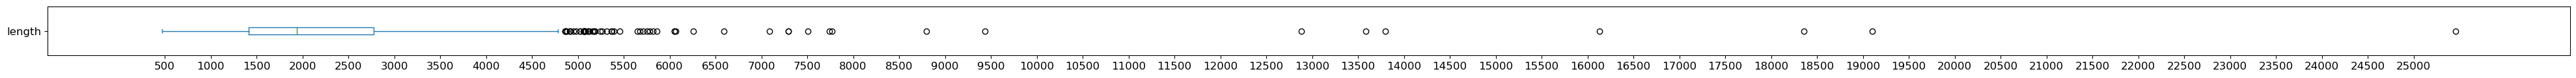

In [64]:
df['length'].plot(kind='box', vert=False, figsize=(50, 1), xticks=np.arange(500, max(df['length'])+1, 500.0))


<AxesSubplot:>

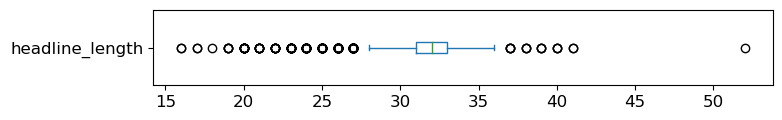

In [12]:
df['headline_length'].plot(kind='box', vert=False, figsize=(8, 1))

<AxesSubplot:ylabel='Frequency'>

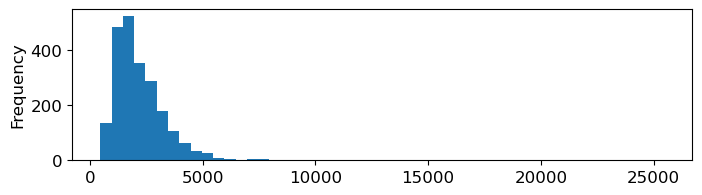

In [14]:
df['length'].plot(kind='hist', bins=50, figsize=(8,2))

<AxesSubplot:ylabel='Frequency'>

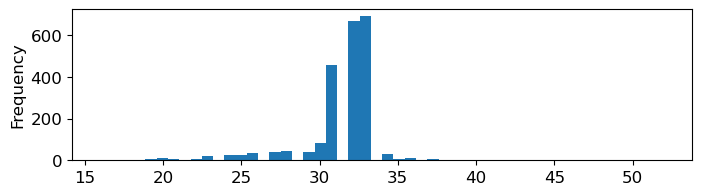

In [15]:
df['headline_length'].plot(kind='hist', bins=50, figsize=(8,2))

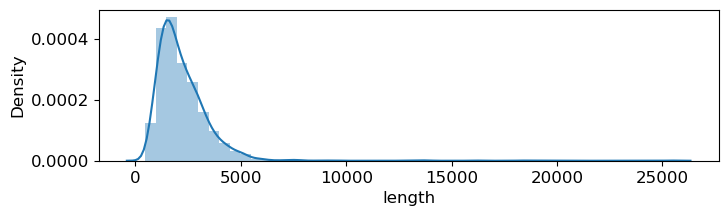

In [16]:
# seaborn plot with gaussian kernel density estimate
import seaborn as sns

plt.figure(figsize=(8, 2))
sns.distplot(df['length'], bins=50, kde=True);

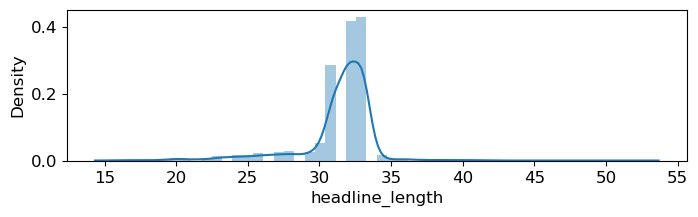

In [17]:
# seaborn plot with gaussian kernel density estimate
import seaborn as sns

plt.figure(figsize=(8, 2))
sns.distplot(df['headline_length'], bins=50, kde=True);

### Comparing Value Distributions Across Categories
Peculiarities in the data often become visible when different subsets of the data are examined. The violin plot is the “smoothed” version of a box plot. Frequencies are visualized by the width of the violin body, while the box is still visible inside the violin. Both plots reveal that the dispersion of values.

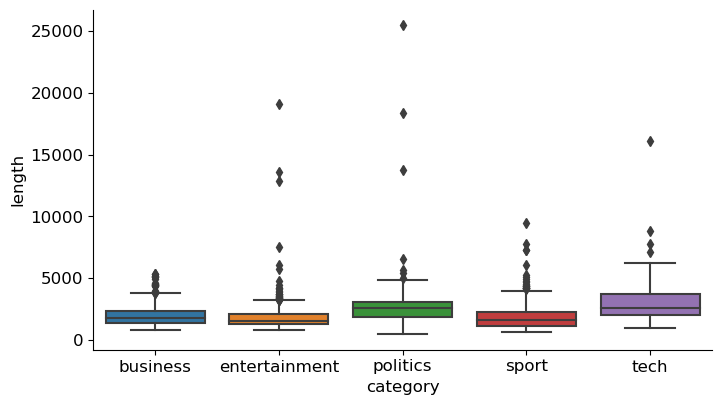

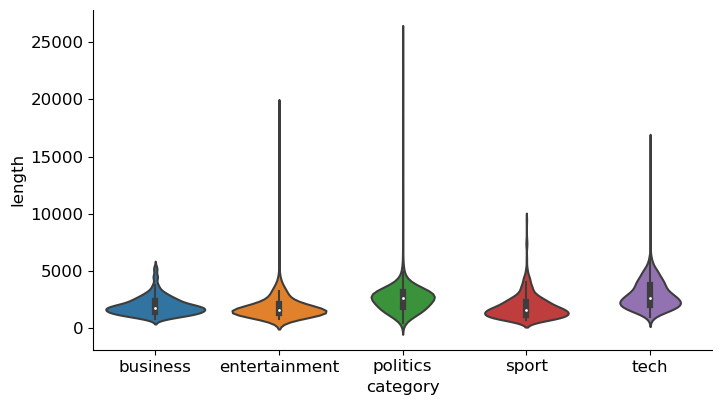

In [26]:
where = df['category'].isin(
    ['business', 'entertainment', 'politics', 'sport', 'tech'])
g = sns.catplot(data=df[where], x="category", y="length", kind='box')
g.fig.set_size_inches(8, 4)
g.fig.set_dpi(100)
g = sns.catplot(data=df[where], x="category", y="length", kind='violin')
g.fig.set_size_inches(8, 4)
g.fig.set_dpi(100)


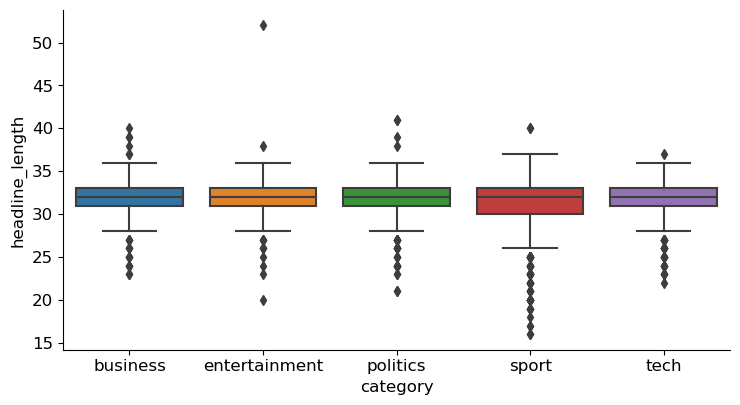

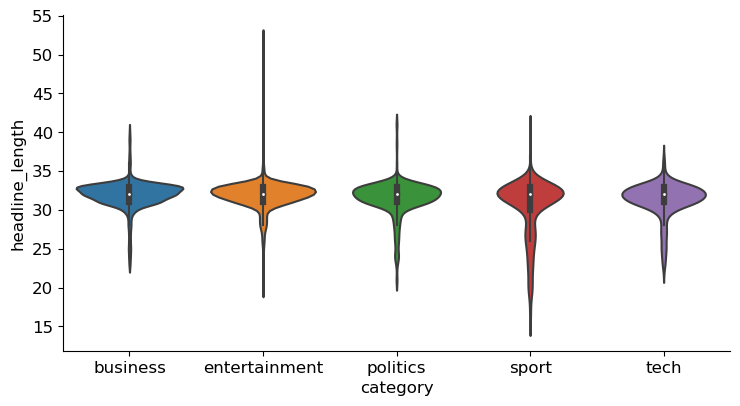

In [27]:
where = df['category'].isin(
    ['business', 'entertainment', 'politics', 'sport', 'tech'])
g = sns.catplot(data=df[where], x="category", y="headline_length", kind='box')
g.fig.set_size_inches(8, 4)
g.fig.set_dpi(100)
g = sns.catplot(data=df[where], x="category", y="headline_length", kind='violin')
g.fig.set_size_inches(8, 4)
g.fig.set_dpi(100)


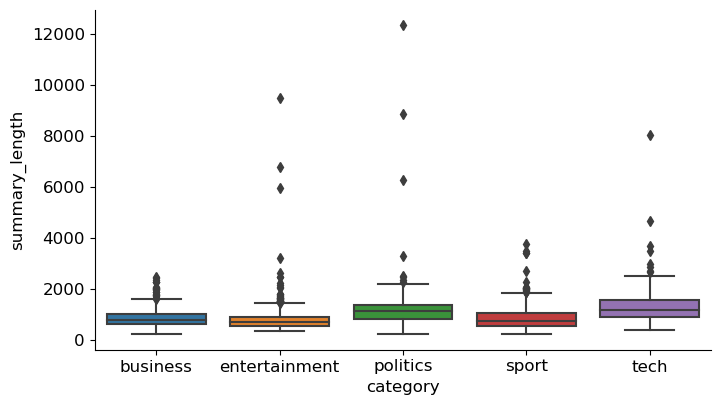

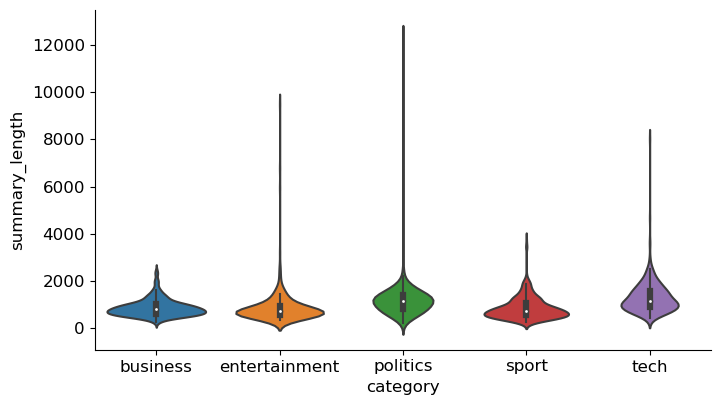

In [29]:
where = df['category'].isin(
    ['business', 'entertainment', 'politics', 'sport', 'tech'])
g = sns.catplot(data=df[where], x="category", y="summary_length", kind='box')
g.fig.set_size_inches(8, 4)
g.fig.set_dpi(100)
g = sns.catplot(data=df[where], x="category", y="summary_length", kind='violin')
g.fig.set_size_inches(8, 4)
g.fig.set_dpi(100)


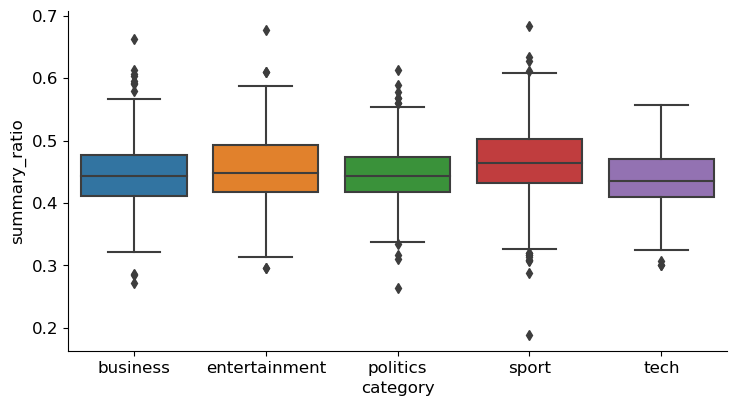

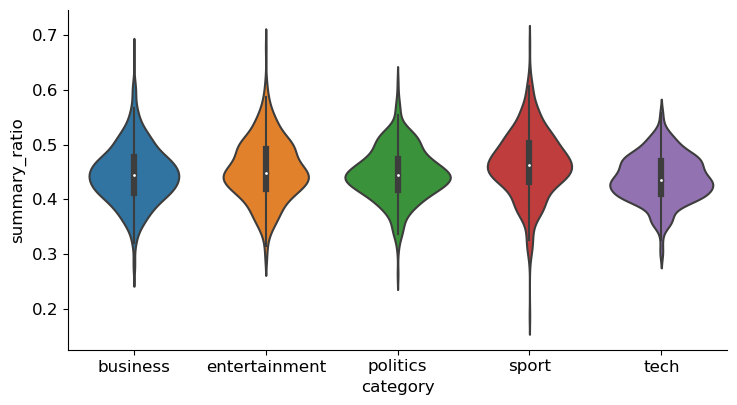

In [31]:
where = df['category'].isin(
    ['business', 'entertainment', 'politics', 'sport', 'tech'])
g = sns.catplot(data=df[where], x="category", y="summary_ratio", kind='box')
g.fig.set_size_inches(8, 4)
g.fig.set_dpi(100)
g = sns.catplot(data=df[where], x="category", y="summary_ratio", kind='violin')
g.fig.set_size_inches(8, 4)
g.fig.set_dpi(100)


In [21]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [22]:
import nltk
# not in book: make sure stop words are available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\furyx\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [17]:
import nltk

stopwords = set(nltk.corpus.stopwords.words('english'))

In [18]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [19]:
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

In [23]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [24]:
df['tokens'] = df['article'].progress_apply(prepare, pipeline=pipeline)

100%|██████████| 2225/2225 [00:01<00:00, 1483.10it/s]


In [25]:
df['num_tokens'] = df['tokens'].progress_map(len)

100%|██████████| 2225/2225 [00:00<00:00, 445350.82it/s]


In [26]:
from collections import Counter
counter = Counter()
_ = df['tokens'].map(counter.update)

pp.pprint(counter.most_common(50))

[('said', 7254),
 ('mr', 3005),
 ('people', 2041),
 ('new', 1901),
 ('us', 1818),
 ('year', 1815),
 ('one', 1757),
 ('could', 1496),
 ('last', 1375),
 ('first', 1273),
 ('two', 1176),
 ('world', 1166),
 ('government', 1152),
 ('time', 1141),
 ('uk', 1026),
 ('years', 998),
 ('against', 964),
 ('best', 920),
 ('make', 913),
 ('told', 910),
 ('get', 873),
 ('made', 855),
 ('game', 847),
 ('like', 838),
 ('many', 828),
 ('music', 812),
 ('film', 809),
 ('next', 775),
 ('labour', 766),
 ('three', 761),
 ('number', 753),
 ('bbc', 750),
 ('back', 742),
 ('added', 731),
 ('way', 723),
 ('take', 722),
 ('well', 701),
 ('set', 682),
 ('company', 681),
 ('may', 679),
 ('market', 671),
 ('says', 667),
 ('home', 641),
 ('good', 640),
 ('going', 624),
 ('still', 617),
 ('much', 609),
 ('party', 607),
 ('since', 606),
 ('games', 601)]


In [27]:
from collections import Counter ###
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [28]:
freq_df = count_words(df)


100%|██████████| 2225/2225 [00:00<00:00, 13907.13it/s]


In [29]:
freq_df.head(60)

,freq
token,
said,7254
mr,3005
people,2041
new,1901
us,1818
year,1815
one,1757
could,1496
last,1375


In [31]:
# top words with 10+ characters
count_words(df, column='article', 
            preprocess=lambda text: re.findall(r"\w{10,}", text)).head(5)

100%|██████████| 2225/2225 [00:00<00:00, 2566.87it/s]


,freq
token,
government,1110
technology,536
information,328
international,245
performance,229


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

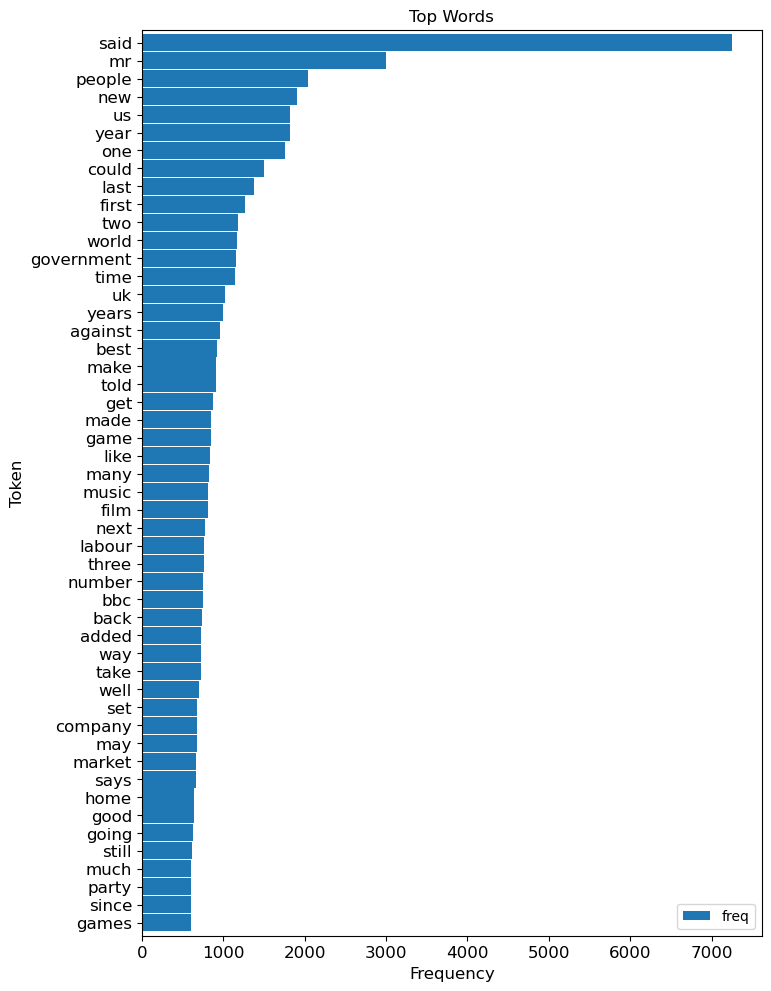

In [32]:
ax = freq_df.head(50).plot(kind='barh', width=0.95, figsize=(8,12))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

In [42]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = freq_df #['token']
text.head
# plt.figure(figsize=(15, 12)) ###
# wc = WordCloud(max_words=100, stopwords=stopwords)
# wc.generate(text)
# plt.imshow(wc, interpolation='bilinear')
# plt.axis("off")

<bound method NDFrame.head of           freq
token         
said      7254
mr        3005
people    2041
new       1901
us        1818
...        ...
artistry     2
eaa          2
frances      2
widowed      2
alot         2

[19644 rows x 1 columns]>

In [30]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")